In [2]:
import os
import pandas as pd
import glob

import xgboost
print(xgboost.__version__)

from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

%config InlineBackend.figure_formatrmat = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/kmenear/Projects/sulfurTES/sulfurTESenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.5.0


In [3]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})
scenario_index

,filepath
0,../data/Air_Models/IG_500_390.csv
1,../data/Air_Models/IG_520_300.csv
2,../data/Air_Models/IG_530_300.csv
3,../data/Air_Models/IG_600_560.csv
4,../data/Air_Models/IG_600_400.csv
...,...
135,../data/Air_Models/IG_370_300.csv
136,../data/Air_Models/IG_600_550.csv
137,../data/Air_Models/IG_600_430.csv
138,../data/Air_Models/IG_550_340.csv


In [4]:
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=5)

train_index, test_index  = next(cv.split(scenario_index.index))

#train_index, test_index = cv.split(range(50))
 
print("TRAIN:", train_index, "TEST:", test_index)
print("TRAIN count:", len(train_index), "TEST count:", len(test_index))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  11  13  14  15  16  17  18  19
  20  22  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41
  42  44  45  47  49  51  55  56  57  58  59  61  62  63  64  65  67  68
  69  71  72  73  76  77  78  79  80  81  82  83  84  85  86  87  88  91
  92  93  95  96  97  99 100 101 103 104 105 106 110 112 113 114 115 116
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139] TEST: [ 10  12  21  23  25  40  43  46  48  50  52  53  54  60  66  70  74  75
  89  90  94  98 102 107 108 109 111 117]
TRAIN count: 112 TEST count: 28


In [5]:
def load_data(scenario_index, selected_index):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))

        f_df = pd.read_csv(f, skiprows=12)
        f_df["Tw"] = Tw
        f_df["Ti"] = Ti
        df_arr.append(f_df)
    
    combined_df = pd.concat(df_arr)
    return combined_df

train_df = load_data(scenario_index, train_index)
train_df

,Time,Tc,Tf,Pc,Ra_d,Nu_d,h,dT/dt,rho,beta,k,cp,visc,Pr,cp.1,Tw,Ti
0,0.00,390.000,445.000,1300000.000,518600.0,12.100,31.83,40.0100,10.154148,0.002247,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
1,0.01,390.400,445.200,1301333.636,517100.0,12.090,31.80,39.8300,10.159997,0.002246,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
2,0.02,390.798,445.399,1302661.343,515600.0,12.080,31.78,39.6500,10.165816,0.002245,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
3,0.03,391.195,445.597,1303983.152,514000.0,12.070,31.75,39.4800,10.171603,0.002244,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
4,0.04,391.590,445.795,1305299.092,512500.0,12.060,31.72,39.3000,10.177359,0.002243,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,21.11,498.598,499.299,1661994.056,7647.0,4.103,10.79,0.1729,11.569879,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2112,21.12,498.600,499.300,1661999.818,7638.0,4.102,10.79,0.1726,11.569899,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2113,21.13,498.602,499.301,1662005.571,7628.0,4.100,10.78,0.1723,11.569919,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2114,21.14,498.603,499.302,1662011.316,7619.0,4.099,10.78,0.1721,11.569939,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0


In [6]:
X = train_df[["Time", "Tw", "Ti"]].to_numpy()
X.shape

(236992, 3)

In [7]:
y = train_df[["Tc"]].to_numpy().reshape(-1,)
print(y.shape)
y

(236992,)


array([390.   , 390.4  , 390.798, ..., 498.602, 498.603, 498.605])

In [8]:
test_df = load_data(scenario_index, test_index)
X_test = test_df[["Time", "Tw", "Ti"]].to_numpy()
y_test = test_df[["Tc"]].to_numpy().reshape(-1,)
print(X_test.shape, y_test.shape)

(59248, 3) (59248,)


In [ ]:

eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

In [9]:
model = XGBRegressor(n_estimators=1000, colsample_bylevel=.75)
model.fit(X, y)

# make a single prediction
#row = [0.20543991,-0.97049844,-0.81403429,-0.23842689,-0.60704084,-0.48541492,0.53113006,2.01834338,-0.90745243,-1.85859731,-1.02334791,-0.6877744,0.60984819,-0.70630121,-1.29161497,1.32385441,1.42150747,1.26567231,2.56569098,-0.11154792]
#row = asarray([row])

yhat = model.predict(X_test)
print('Predictions:', yhat)
print('Expected values:', y_test)

Predictions: [379.80707 380.82492 381.63235 ... 548.6208  548.6208  548.6208 ]
Expected values: [370.    370.928 371.852 ... 549.423 549.423 549.424]


In [10]:
test_df["Tc_hat"] = yhat
test_df

,Time,Tc,Tf,Pc,Ra_d,Nu_d,h,dT/dt,rho,beta,k,cp,visc,Pr,cp.1,Tw,Ti,Tc_hat
0,0.00,370.000,485.000,1233333.333,753900.0,13.420,35.310,92.80000,8.838913,0.002062,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,379.807068
1,0.01,370.928,485.464,1236426.650,752400.0,13.420,35.290,92.38000,8.852613,0.002060,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,380.824921
2,0.02,371.852,485.926,1239505.853,751000.0,13.410,35.270,91.95000,8.866224,0.002058,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,381.632355
3,0.03,372.771,486.386,1242570.998,749500.0,13.400,35.250,91.53000,8.879747,0.002056,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,382.403076
4,0.04,373.687,486.843,1245622.143,748100.0,13.400,35.230,91.12000,8.893183,0.002054,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,383.673492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,21.11,549.421,549.711,1831404.559,2872.0,3.279,8.624,0.05703,11.580045,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,548.606750
2112,21.12,549.422,549.711,1831406.460,2869.0,3.279,8.622,0.05696,11.580051,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,548.606750
2113,21.13,549.423,549.711,1831408.359,2866.0,3.278,8.621,0.05689,11.580057,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,548.620789
2114,21.14,549.423,549.712,1831410.255,2864.0,3.277,8.619,0.05682,11.580063,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,548.620789


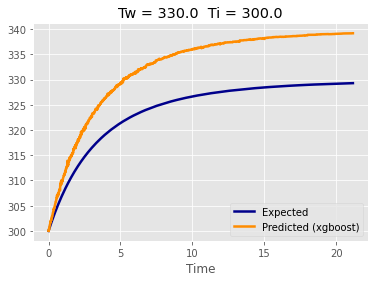

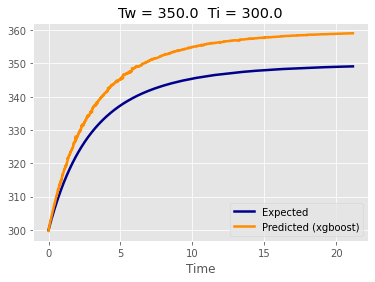

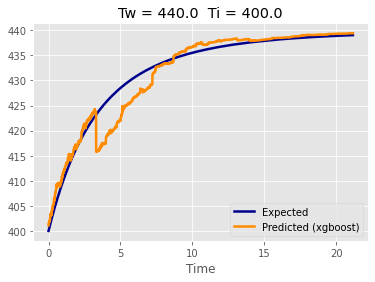

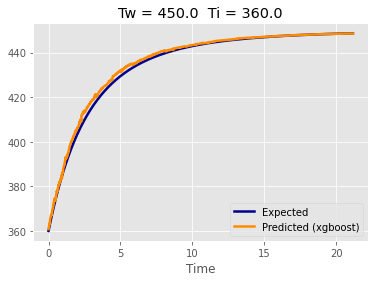

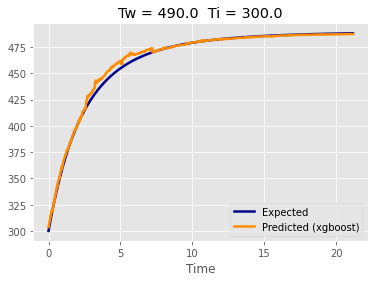

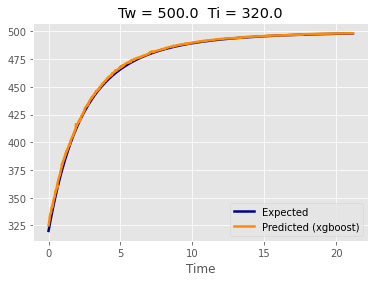

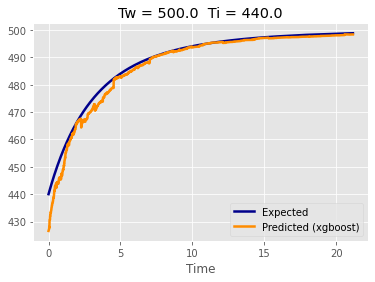

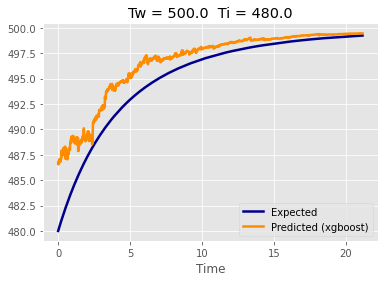

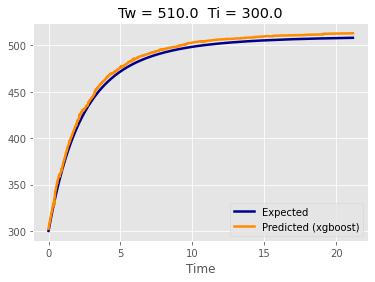

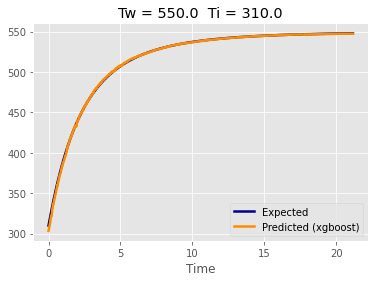

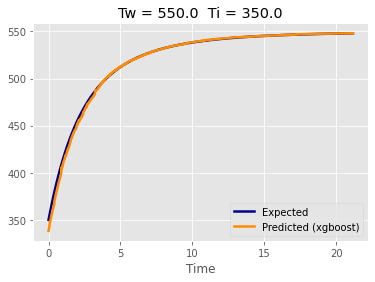

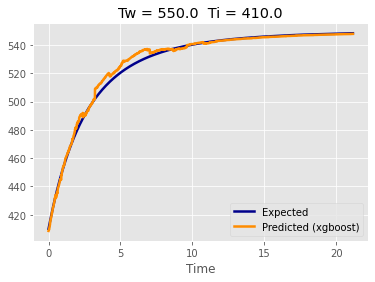

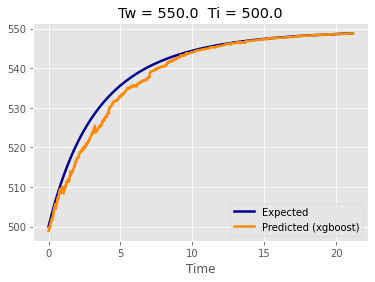

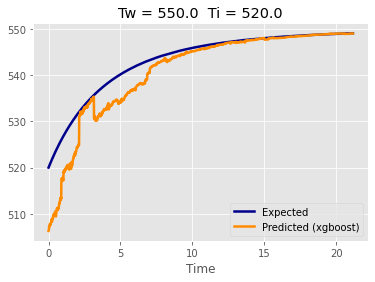

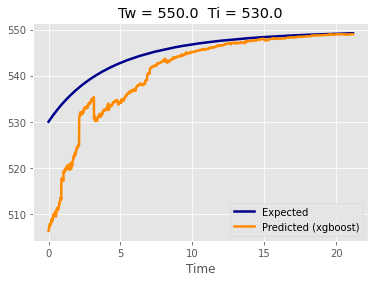

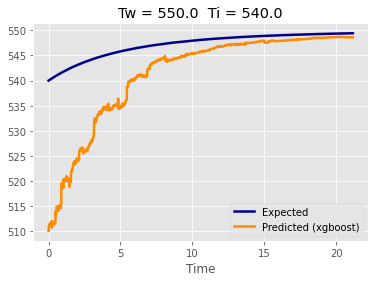

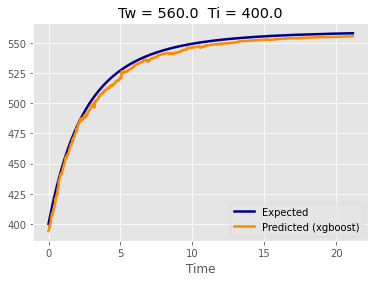

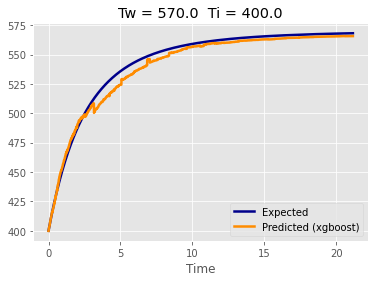

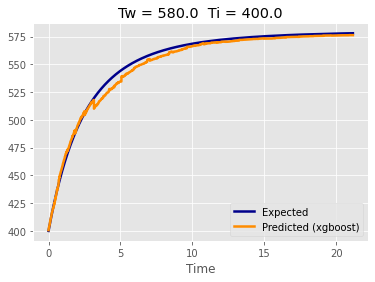

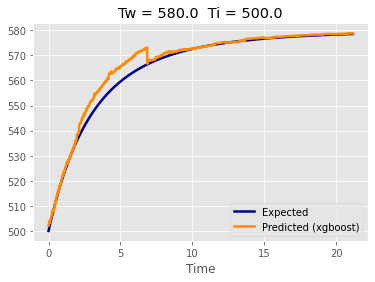

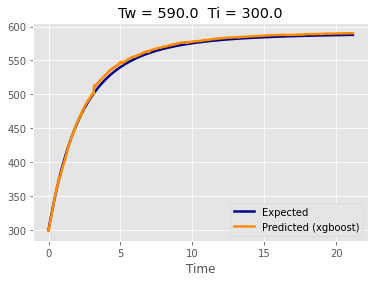

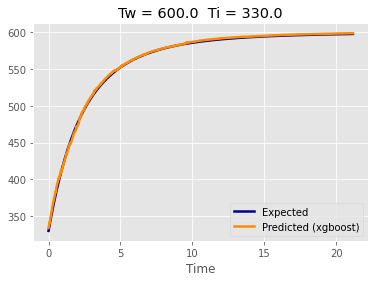

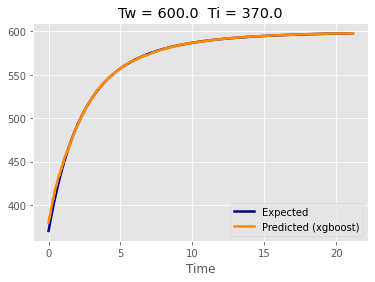

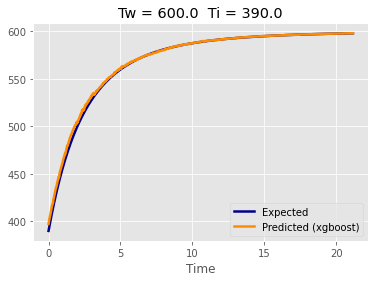

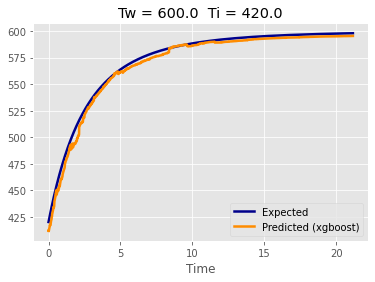

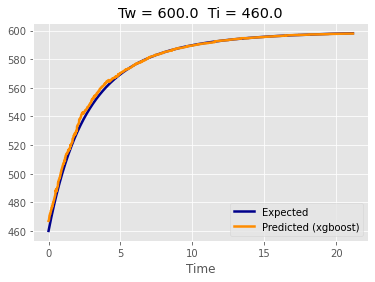

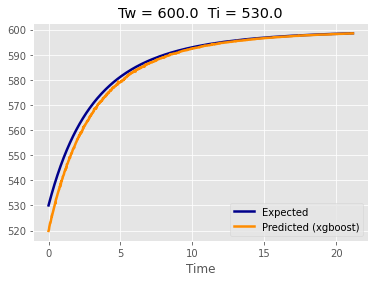

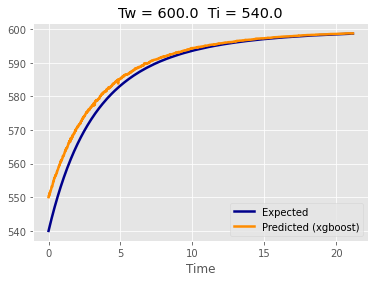

In [11]:
import matplotlib
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    ax = grp.plot(x="Time", y='Tc', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="Time", y='Tc_hat', c='DarkOrange', linewidth=2.5, label="Predicted (xgboost)", ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    #plot.set_ylim(bottom=300.0,top=600.0)
    plt.show()

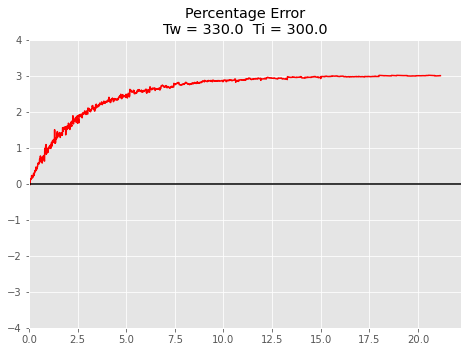

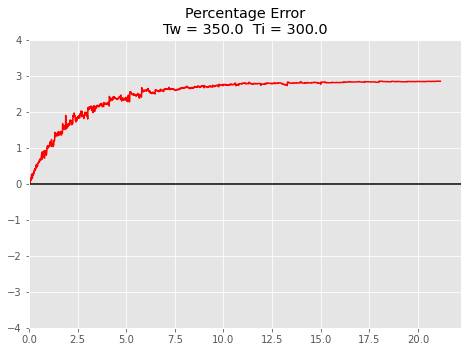

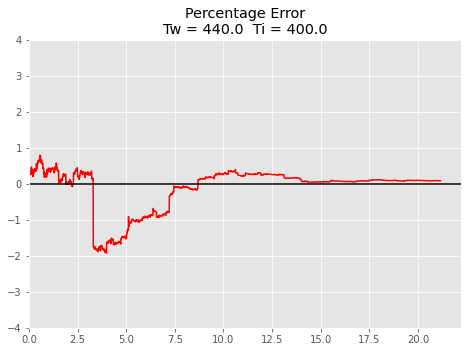

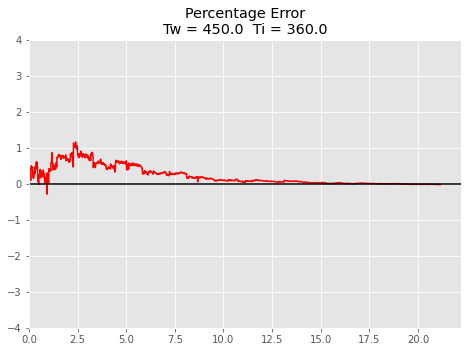

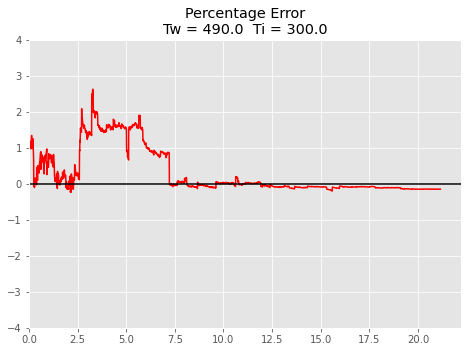

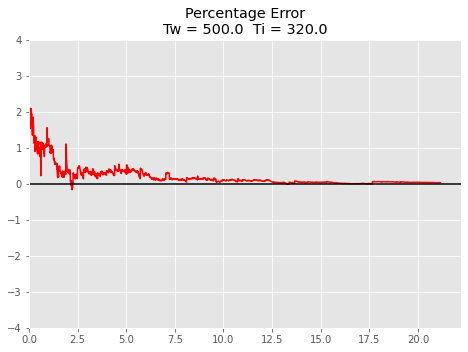

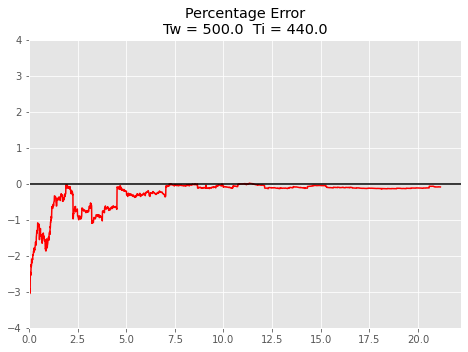

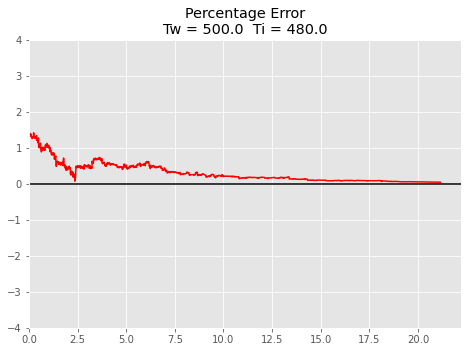

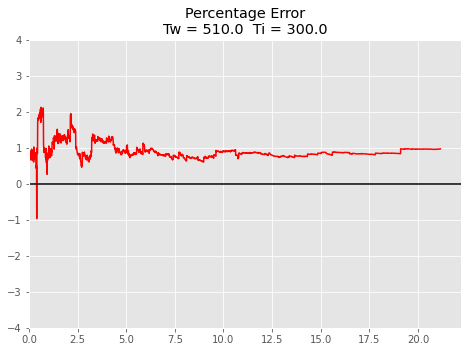

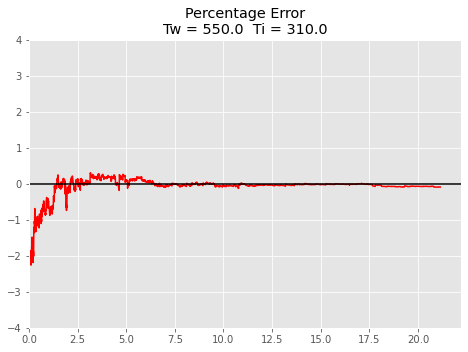

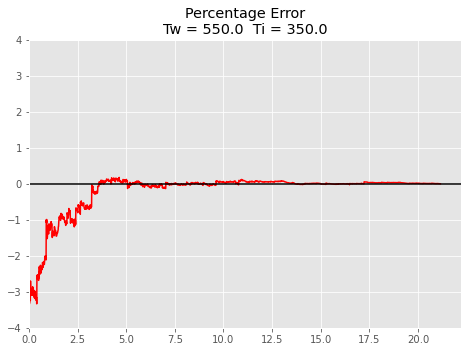

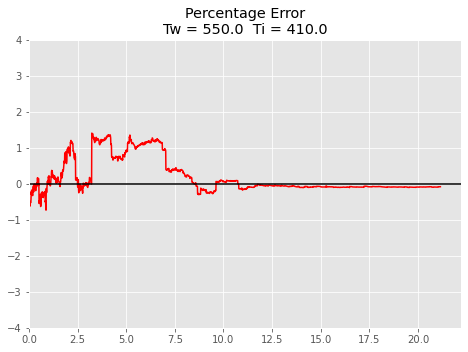

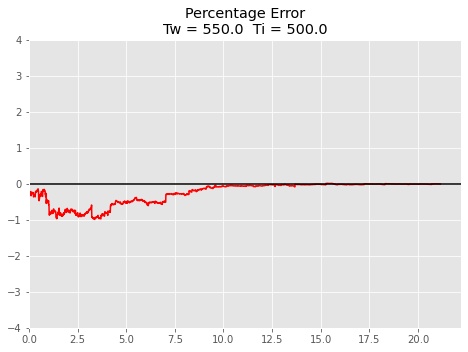

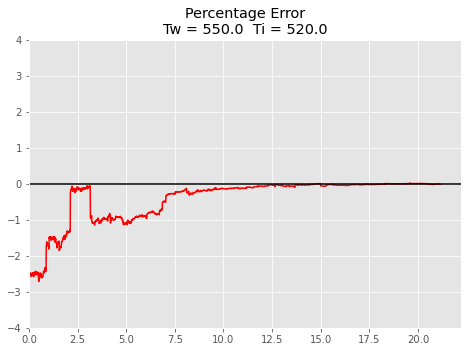

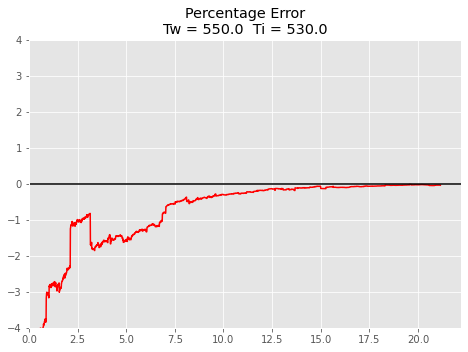

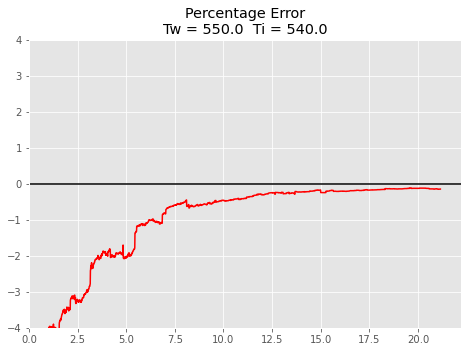

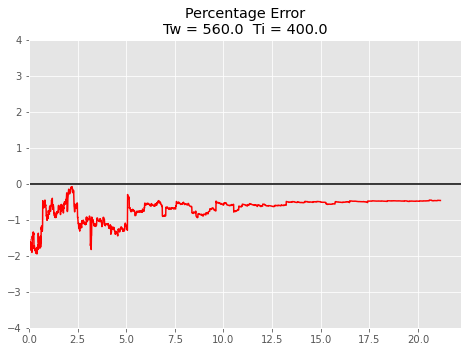

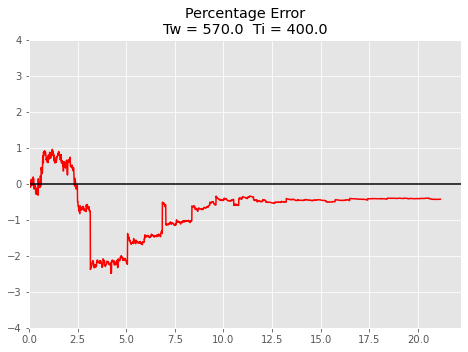

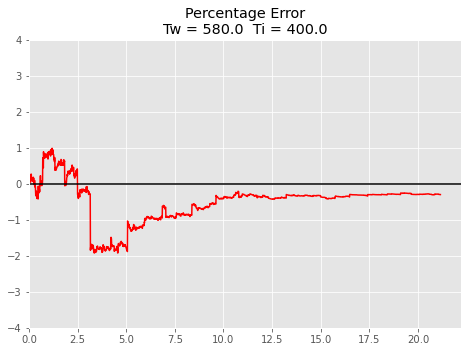

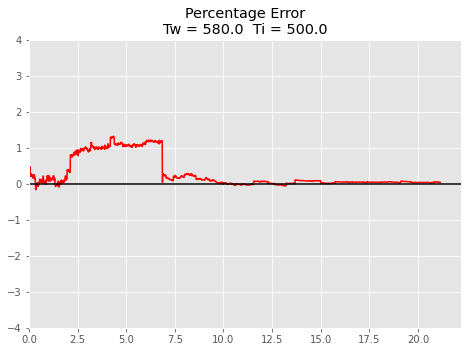

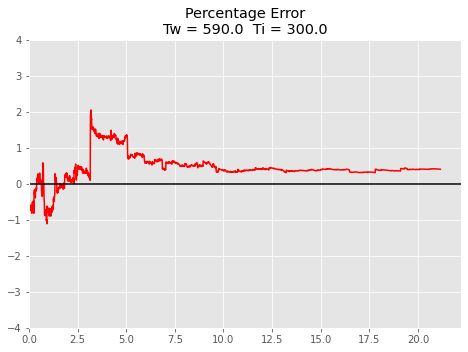

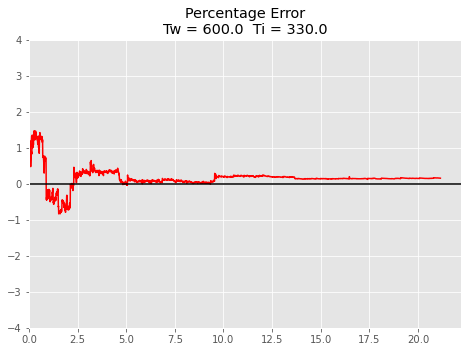

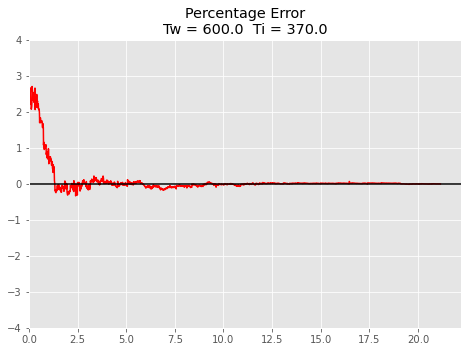

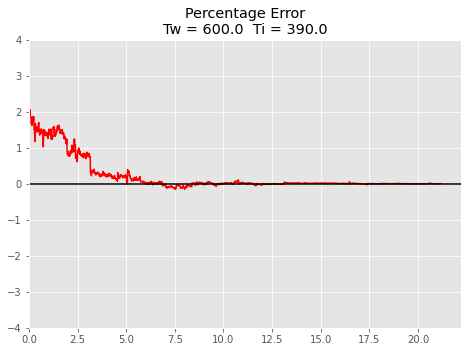

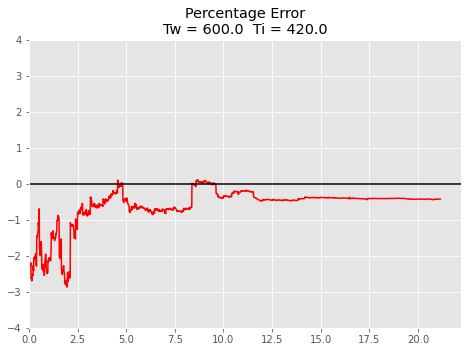

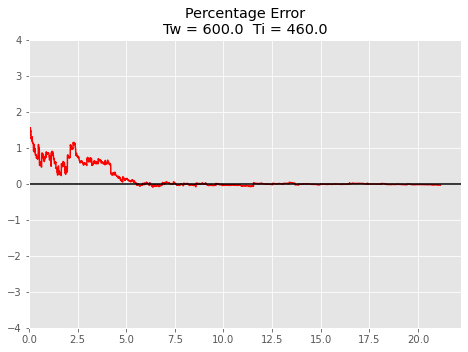

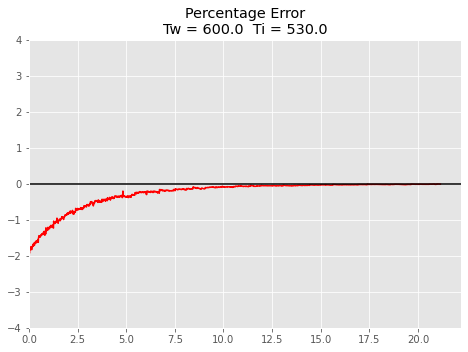

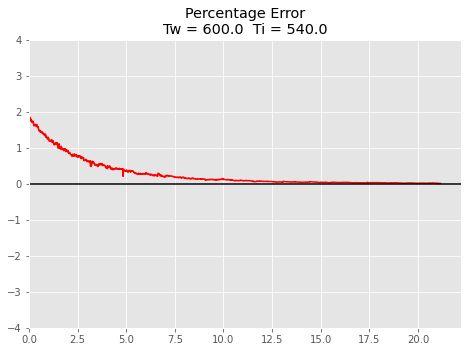

In [12]:
import matplotlib
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    err = 100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc']
    ax = plt.figure().add_axes([0,0,1,1])
    ax.plot(grp['Time'], err, color='r')
    ax.set_ylim(bottom=-4,top=4)
    ax.set_xlim(left=0)
    plt.title('Percentage Error\nTw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    plt.axhline(0, color='black')
    plt.show()

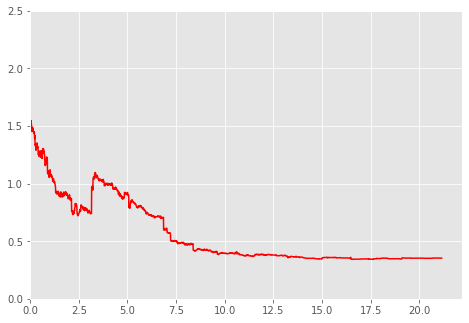

In [23]:
count = 0
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    if count == 0:
        avg_err = abs(100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc'])
    else:
        avg_err += abs(100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc'])
    count += 1

avg_err /= count
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(grp['Time'], avg_err, color='r')
ax.set_ylim(bottom=0,top=2.5)
ax.set_xlim(left=0)
#plt.title('Average Percentage Error at Time Step t')
#plt.axhline(0, color='black')
plt.show()

<AxesSubplot:>

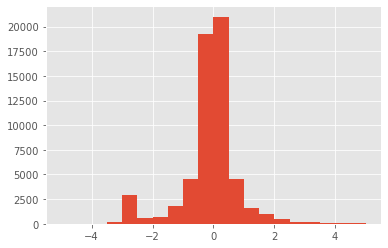

In [13]:
(100*(test_df["Tc"] - test_df["Tc_hat"])/test_df["Tc"]).hist(bins=20, range=(-5, 5))

<AxesSubplot:>

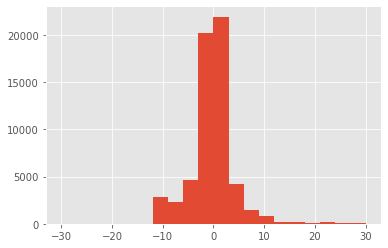

In [19]:
(test_df["Tc"] - test_df["Tc_hat"]).hist(bins=20, range=(-30, 30))

In [15]:
perc_err = (test_df["Tc_hat"] - test_df["Tc"])/test_df["Tc"]
avg_err = 0
cnt = 0
for item in perc_err:
    avg_err += abs(item)
    cnt += 1

avg_err /= cnt
acc = 1 - avg_err
print('Accuracy:',acc)

Accuracy: 0.9943981102972358


In [56]:
Tdiff_err = [[],[]]
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    grp_diff = abs(grp["Tc"] - grp["Tc_hat"])
    avg_err = grp_diff.sum()
    T_diff = idx[0] - idx[1]
    print(idx, T_diff, avg_err)
    Tdiff_err[0].append(T_diff)
    Tdiff_err[1].append(avg_err)

(330.0, 300.0) 30.0 17845.339696777344
(350.0, 300.0) 50.0 18090.209547851562
(440.0, 400.0) 40.0 2349.5732114257835
(450.0, 360.0) 90.0 2412.269189697266
(490.0, 300.0) 190.0 3390.058702392577
(500.0, 320.0) 180.0 2757.873685058594
(500.0, 440.0) 60.0 1733.744091064454
(500.0, 480.0) 20.0 2590.2098386230473
(510.0, 300.0) 210.0 2690.0411091308597
(550.0, 310.0) 240.0 917.2020178222673
(550.0, 350.0) 200.0 901.5504116210911
(550.0, 410.0) 140.0 2626.7644443359372
(550.0, 500.0) 50.0 2494.3234072265623
(550.0, 520.0) 30.0 3949.8257416992196
(550.0, 530.0) 20.0 5551.954422363282
(550.0, 540.0) 10.0 8133.413678222656
(560.0, 400.0) 160.0 1686.4172717285155
(570.0, 400.0) 170.0 2686.013533447264
(580.0, 400.0) 180.0 4080.864962646483
(580.0, 500.0) 80.0 4853.038260742189
(590.0, 300.0) 290.0 4309.430032470702
(600.0, 330.0) 270.0 620.2455917968742
(600.0, 370.0) 230.0 1092.3560517578153
(600.0, 390.0) 210.0 1221.508366455077
(600.0, 420.0) 180.0 2536.855621826173
(600.0, 460.0) 140.0 2083.

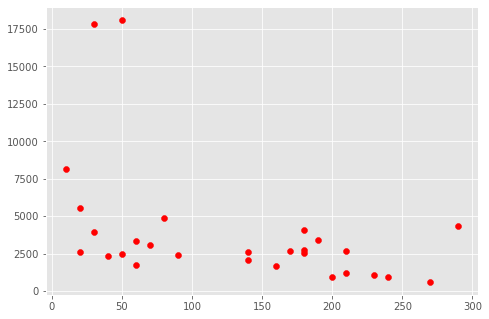

In [57]:
ax = plt.figure().add_axes([0,0,1,1])
ax.scatter(Tdiff_err[0], Tdiff_err[1], color='r')
plt.show()

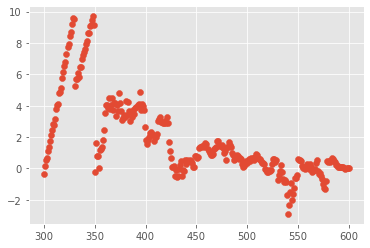

In [58]:
import math

avg_tc_diff = {}

for i in range(300, 601):
    avg_tc_diff[i] = [0,0]

tc_hat_list = test_df['Tc_hat'].tolist()
for i, temp in enumerate(test_df["Tc"]):
    avg_tc_diff[math.floor(temp)][0] += tc_hat_list[i] - temp
    avg_tc_diff[math.floor(temp)][1] += 1

temp = []
diff = []
for key, value in avg_tc_diff.items():
    if avg_tc_diff[key][1] > 0:
        avg_tc_diff[key][0] /= avg_tc_diff[key][1]
    temp.append(key)
    diff.append(avg_tc_diff[key][0])
    
plt.scatter(temp, diff)
plt.show()

In [59]:
print(r2_score(test_df["Tc"],test_df["Tc_hat"]))

0.9980546713926032
